In [149]:
import numpy as np
import matplotlib.pyplot as plt

# Training a Neural Network with NumPy

This notebook presents a pedagogical implementation of neural network training using only the `NumPy` library for basic array computations. 

Specifically, we seek to determine the optimal weights of a single-hidden-layer network that approximates the function $y = \sin(x)$ on the domain $(-\pi, \pi)$.

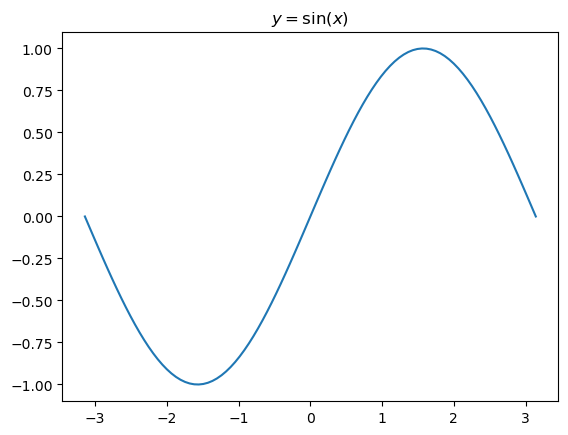

In [150]:
x = np.linspace(-np.pi, np.pi, 100)
y = np.sin(x)

plt.plot(x, y)
plt.title(r'$y=\sin(x)$')
plt.show()

### Neural Network Definition

A neural network is a parameterised function that maps an input vector $x_b$ to an output vector $\hat{y}$:
$$
\hat{y} = f(x_b;\,\theta),
$$
where $\theta$ denotes the collection of parameters (weights and biases).

The function $f(\cdot)$ is constructed by composing elementary building blocks, each consisting of:

- an affine transformation $z = x W + b$,
- followed by a pointwise nonlinear transformation $a = \sigma(z)$,

where the output of one layer serves as the input to the subsequent layer.

**Rationale for this structure:**
- The **affine component** ($xW + b$) performs a linear transformation that can scale, rotate, and translate the input space
- The **nonlinear component** ($\sigma$) introduces curvature, enabling the network to approximate nonlinear mappings

**The Necessity of Nonlinear Activation**

Without nonlinearity, composing multiple layers is algebraically equivalent to a single affine transformation. 

To see this, consider two successive linear layers without activation:
$$z_2 = (xW_1 + b_1)W_2 + b_2 = x(W_1 W_2) + (b_1 W_2 + b_2) = xW' + b'$$

**Universal Approximation Theorem**

A neural network is a parameterised function whose parameters can be adjusted to approximate a broad class of target functions. 

Cybenko, 1989; Hornik et al., 1989: *"A feedforward neural network with a single hidden layer containing a finite number of neurons can approximate any continuous function on compact subsets of $\mathbb{R}^n$ to arbitrary precision, provided the activation function satisfies certain mild regularity conditions."*

### Choice of activation Functions

In this example, we employ the hyperbolic tangent function:
$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

The $\tanh$ function possesses several desirable properties:
- **Bounded output:** Values lie in the interval $[-1, 1]$
- **Zero-centred:** $\tanh(0) = 0$, which can facilitate gradient-based optimisation
- **Smooth and differentiable:** $\tanh'(x) = 1 - \tanh(x)^2$

Alternative activation functions commonly used in practice include:
- **ReLU (Rectified Linear Unit):** $\sigma(x) = \max(0, x)$
- **Sigmoid:** $\sigma(x) = 1/(1 + e^{-x})$

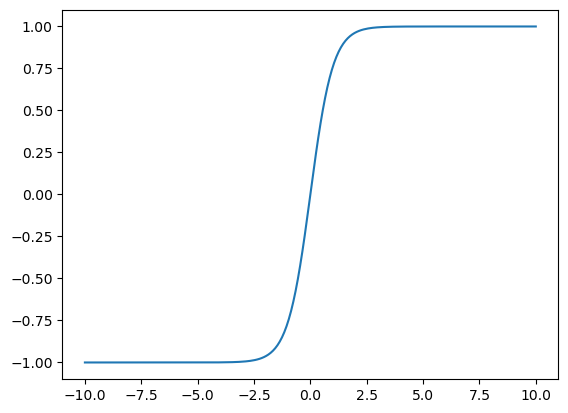

In [151]:
def tanh(z):
    return np.tanh(z)

x = np.linspace(-10, 10, 200)
y = np.tanh(x)
plt.plot(x, y)
plt.show()

### The Optimisation Procedure

The training algorithm proceeds iteratively:

1. **Initialisation:** Set the parameters to random initial values

2. **Forward propagation:** Evaluate the network's output given the current parameters

3. **Loss computation:** Quantify the discrepancy between predictions and target values via an objective function

4. **Gradient computation:** Determine the sensitivity of the loss function with respect to each parameter (backpropagation)

5. **Parameter update:** Adjust parameters in the direction that decreases the loss (gradient descent)

6. **Iteration:** Repeat steps 2–5 until convergence


## 1. Initialisation

We focus on a network with a single hidden layer:

- Batched inputs: $x_b$

- Hidden layer: $z_1 = x_b W_1 + b_1$, $a_1 = \tanh(z_1)$

- Output layer: $\hat{y} = a_1 W_2 + b_2$

To initialize the network with random weights, we need to pay attention to the dimensions of every object.

The dimensional structure is as follows:

- $N_x$: input dimension (here, 1)

- $N_b$: batch size (number of observations processed simultaneously)

- $N_h$: number of neurons in the hidden layer (network width)

- $N_y$: output dimension (here, 1)

The relevant tensors have the following dimensions:

- $x_b \in \mathbb{R}^{N_b \times N_x}$
- $W_1 \in \mathbb{R}^{N_x \times N_h}$
- $b_1 \in \mathbb{R}^{1 \times N_h}$ (broadcast across the batch dimension)
- $z_1, a_1 \in \mathbb{R}^{N_b \times N_h}$
- $W_2 \in \mathbb{R}^{N_h \times N_y}$
- $b_2 \in \mathbb{R}^{1 \times N_y}$ (broadcast across the batch dimension)
- $\hat{y} \in \mathbb{R}^{N_b \times N_y}$

In [152]:
Nx = 1
Nb = 3 
Nh = 10
Ny = 1

# Initialize weights and biases at random values
W1 = np.random.randn(Nx, Nh)
b1 = np.random.randn(Nh)
W2 = np.random.randn(Nh, Ny)
b2 = np.random.randn(Ny)

# draw random input batch
xb = np.random.uniform(-np.pi, np.pi, size=(Nb, 1))

## 2. Forward Propagation

The forward pass refers to the sequential evaluation of the network from input to output. Given input data $x$ and fixed parameter values, we compute the predicted output $\hat{y}$.

At this stage, no learning occurs; we simply evaluate the composition of functions that defines the network.

The forward pass is then computed by sequentially applying the affine and nonlinear transformations.

In [153]:
def tanh(z):
    return np.tanh(z)

# First layer
z1 = xb @ W1 + b1      # (B, H)
a1 = tanh(z1)          # (B, H)

# Second layer (output layer)
yhat = a1 @ W2 + b2    # (B, 1)

In [154]:
# Putting it all together in a function 

def forward(xb, W1, b1, W2, b2):
    z1 = xb @ W1 + b1      # (B, H)
    a1 = tanh(z1)          # (B, H)
    yhat = a1 @ W2 + b2    # (B, 1)
    cache = (xb, z1, a1, yhat)
    return yhat, cache

## 3. Backpropagation

The central question in neural network training is: how should we adjust the parameters to improve predictions?

First, we need to have a measure of how well the network is doing: this is the loss function. 

We employ the **mean squared error (MSE)**:
$$L(\theta) = \frac{1}{N_b}\sum_{i=1}^{N_b}(\hat{y}_i - y_i)^2$$

This choice possesses several desirable properties:

- **Differentiability:** The function is smooth, enabling gradient-based optimisation

- **Convexity in predictions:** Given fixed features, the loss is convex in $\hat{y}$

- **Quadratic penalty:** Larger errors incur disproportionately higher costs

Then, we choose the parameters that minimize this loss function: this is the backpropagation step. 

### The Loss Function

Training the network consists of finding parameter values $\theta = (W_1, W_2, b_1, b_2)$ that minimise a loss function.

We employ the **mean squared error (MSE)**:
$$L(\theta) = \frac{1}{N_b}\sum_{i=1}^{N_b}(\hat{y}_i - y_i)^2$$

This choice possesses several desirable properties:

- **Differentiability:** The function is smooth, enabling gradient-based optimisation

- **Convexity in predictions:** Given fixed features, the loss is convex in $\hat{y}$

- **Quadratic penalty:** Larger errors incur disproportionately higher costs

### Gradient Descent

Our objective is to compute $\nabla_\theta L(\theta)$ to perform **gradient descent**:
$$\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_\theta L(\theta^{(t)})$$

The gradient $\nabla_\theta L$ indicates the direction of steepest ascent. To minimise the loss, we update parameters in the opposite direction, scaled by the **learning rate** $\eta > 0$.

The backward pass computes all necessary gradients: $\partial L / \partial W_1$, $\partial L / \partial b_1$, $\partial L / \partial W_2$, and $\partial L / \partial b_2$.

### Gradient Computation via the Chain Rule

The mathematical foundation is the chain rule of calculus.

By applying this rule recursively, layer by layer, from the output back to the input, we obtain the gradient with respect to every parameter in the network.

#### 3.1 Gradient of the loss with respect to the network output

The loss is the mean squared error
$$
L = \frac{1}{N_b} \sum_{i=1}^{N_b} (\hat y_i - y_i)^2.
$$
Hence, for each observation $i$,
$$
\frac{\partial L}{\partial \hat y_i}
= \frac{2}{N_b} (\hat y_i - y_i).
$$

Stacking over all observations, we define
$$
d y \equiv \frac{\partial L}{\partial \hat y}
= \frac{2}{N_b} (\hat y - y),
$$
where $d y \in \mathbb{R}^{N_b \times 1}$.



In [155]:
x = np.linspace(-np.pi, np.pi, Nb).reshape(-1, 1)
yb = np.sin(x)
dy = (2.0 / Nb) * (yhat - yb) # (B, 1)

#### 3.2 Gradient through the output layer

The output layer is given by
$$
\hat y = a_1 W_2 + b_2,
$$
where $a_1 \in \mathbb{R}^{N_b \times H}$, $W_2 \in \mathbb{R}^{H \times 1}$, and $b_2 \in \mathbb{R}$.

For a single observation $i$,
$$
\hat y_i = \sum_{j=1}^H a_{1,ij} W_{2,j} + b_2.
$$
Therefore,
$$
\frac{\partial \hat y_i}{\partial W_{2,j}} = a_{1,ij}.
$$

Applying the chain rule, we obtain
$$
\frac{\partial L}{\partial W_{2,j}}
= \sum_{i=1}^{N_b}
\frac{\partial L}{\partial \hat y_i}
\frac{\partial \hat y_i}{\partial W_{2,j}}
= \sum_{i=1}^{N_b} d y_i \, a_{1,ij}.
$$

In matrix form, this can be written compactly as
$$
\frac{\partial L}{\partial W_2} = a_1^\top d y.
$$

For $b_2$, note that $\partial \hat{y}_i/db_2=1$, so that $\partial L/\partial b_2 = \sum_{i=1}^{N_b} dy_i$. 

In [156]:
dW2 = a1.T @ dy                         # (H, 1)
db2 = dy.sum(axis=0, keepdims=True)     # (1, 1)

#### 3.2 bis Backpropagation through tanh 

We know that $z_1 = \tanh(a_1)$. Applying the chain rule again yields
$$\frac{\partial L}{\partial z_1}=\frac{\partial L}{\partial a_1}\times \frac{\partial a_1}{\partial z_1}= da_1 \times (1-\tanh(z_1)^2)$$
(where $\times$ is an elementwise multiplication). 

We used the fact that the derivative $\tanh'(x)$ is given by $1-\tanh(x)^2$. 

For $da_1$, we have 
$$\frac{\partial L}{\partial a_{1,i}}=\frac{\partial L}{\partial \hat{y_i}}\frac{\partial \hat{y_i}}{\partial a_{1,i}}=dy W_2^T$$

In [157]:
def dtanh(z):
    # derivative wrt pre-activation z: 1 - tanh(z)^2
    t = np.tanh(z)
    return 1.0 - t**2

da1 = dy @ W2.T                         # (B, H)
dz1 = da1 * dtanh(z1)                   # (B, H)

#### 3.3 Gradient through the first layer 

Now, we have $z_1=x_bW_1+b_1$, and $\partial z_1/\partial W_1=x_b$. Thus
$$\frac{\partial L}{\partial W_{1,j}}=\sum_{i=1}^{N_b}\frac{\partial L}{\partial z_{1,ij}}x_{b,i}.$$
In matrix form, this yields 
$$\frac{\partial L}{\partial W_1}= x_b^{T} dz_1$$

In [158]:
dW1 = xb.T @ dz1                         # (1, H)
db1 = dz1.sum(axis=0, keepdims=True)     # (1, H)

Consolidating the above derivations into a single function:

In [159]:
def backward(cache, yb, W2):
    xb, z1, a1, yhat = cache
    B = xb.shape[0]

    # MSE loss: L = mean((yhat - y)^2)
    # dL/dyhat = 2*(yhat - y)/B
    dy = (2.0 / B) * (yhat - yb)            # (B, 1)

    # yhat = a1 W2 + b2
    dW2 = a1.T @ dy                         # (H, 1)
    db2 = dy.sum(axis=0, keepdims=True)     # (1, 1)
    da1 = dy @ W2.T                         # (B, H)

    # a1 = tanh(z1)
    dz1 = da1 * dtanh(z1)                   # (B, H)

    # z1 = x W1 + b1
    dW1 = xb.T @ dz1                         # (1, H)
    db1 = dz1.sum(axis=0, keepdims=True)     # (1, H)

    return dW1, db1, dW2, db2

## 4. Stochastic Gradient Descent and Training

We now integrate the forward and backward passes with the gradient descent update rule.


In [160]:
# drawing the data
np.random.seed(0)

n = 512
x = np.random.uniform(-np.pi, np.pi, size=(n, 1))
y = np.sin(x)

In [161]:
# normalize inputs (helps training)
x_mean, x_std = x.mean(), x.std()
x_n = (x - x_mean) / x_std

**Input Normalisation:** Standardising inputs to have zero mean and unit variance facilitates training:
- Ensures comparable scales across input features
- Improves conditioning of the optimisation landscape
- Accelerates convergence by preventing certain weights from dominating the gradient

In [162]:
# Initialize network parameters

Nh = 32
W1 = 0.1 * np.random.randn(1, Nh)
b1 = np.zeros((1, Nh))
W2 = 0.1 * np.random.randn(Nh, 1)
b2 = np.zeros((1, 1))

In [163]:
# Create a validation set
n_validation = 1024
x_validation = np.linspace(-np.pi, np.pi, n_validation).reshape(-1, 1)

### Full-Batch Gradient Descent

In [164]:
# Full (batch) gradient descent training loop

lr = 1e-1
epochs = 20_000          # rename "steps" -> epochs (one update per full pass)
losses = []

# Pre-compute fixed validation targets once
x_val_n = (x_validation - x_mean) / x_std
y_val = np.sin(x_validation)

for t in range(epochs):
    # Use the full training set (no mini-batch sampling)
    xb = x_n              # shape (n, 1)
    yb = y                # shape (n, 1)

    # Forward-pass on full data
    yhat, cache = forward(xb, W1, b1, W2, b2)

    # Backward-propagation on full data (exact gradient of empirical risk)
    dW1, db1, dW2, db2 = backward(cache, yb, W2)

    # Gradient descent update
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    # Validation loss (fixed set)
    if t % 100 == 0:
        y_val_pred, _ = forward(x_val_n, W1, b1, W2, b2)
        loss = np.mean((y_val_pred - y_val) ** 2)
        print(f"epoch {t+1:4d} | loss {np.sqrt(loss):.6f}")
        losses.append(loss)


epoch    1 | loss 0.681950
epoch  101 | loss 0.430671
epoch  201 | loss 0.392797
epoch  301 | loss 0.266317
epoch  401 | loss 0.157583
epoch  501 | loss 0.128081
epoch  601 | loss 0.119420
epoch  701 | loss 0.113043
epoch  801 | loss 0.107251
epoch  901 | loss 0.101944
epoch 1001 | loss 0.097087
epoch 1101 | loss 0.092642
epoch 1201 | loss 0.088570
epoch 1301 | loss 0.084837
epoch 1401 | loss 0.081413
epoch 1501 | loss 0.078272
epoch 1601 | loss 0.075391
epoch 1701 | loss 0.072749
epoch 1801 | loss 0.070326
epoch 1901 | loss 0.068102
epoch 2001 | loss 0.066061
epoch 2101 | loss 0.064185
epoch 2201 | loss 0.062459
epoch 2301 | loss 0.060869
epoch 2401 | loss 0.059400
epoch 2501 | loss 0.058041
epoch 2601 | loss 0.056780
epoch 2701 | loss 0.055607
epoch 2801 | loss 0.054514
epoch 2901 | loss 0.053492
epoch 3001 | loss 0.052535
epoch 3101 | loss 0.051635
epoch 3201 | loss 0.050786
epoch 3301 | loss 0.049985
epoch 3401 | loss 0.049226
epoch 3501 | loss 0.048505
epoch 3601 | loss 0.047819
e

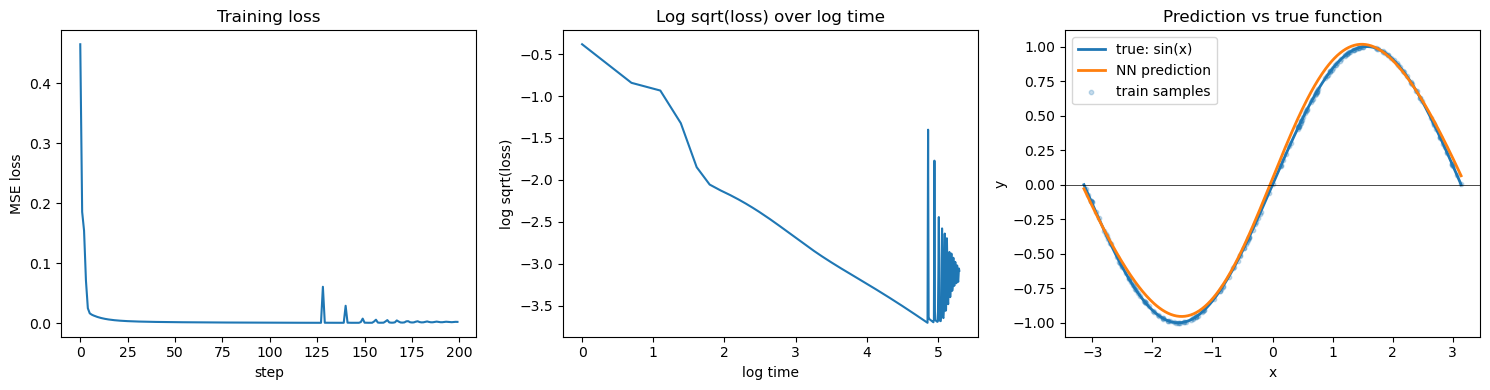

In [165]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# -------------------------------------------------
# 1) Training loss (MSE)
# -------------------------------------------------
axes[0].plot(losses)
axes[0].set_xlabel("step")
axes[0].set_ylabel("MSE loss")
axes[0].set_title("Training loss")

# -------------------------------------------------
# 2) Log–log plot of sqrt(loss)
# -------------------------------------------------
t = np.arange(1, len(losses) + 1)
axes[1].plot(np.log(t), np.log(np.sqrt(losses)))
axes[1].set_xlabel("log time")
axes[1].set_ylabel("log sqrt(loss)")
axes[1].set_title("Log sqrt(loss) over log time")

# -------------------------------------------------
# 3) Prediction vs true function
# -------------------------------------------------
x_grid = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1)
y_true = np.sin(x_grid)

x_grid_n = (x_grid - x_mean) / x_std
y_pred, _ = forward(x_grid_n, W1, b1, W2, b2)

axes[2].plot(x_grid, y_true, label="true: sin(x)", linewidth=2)
axes[2].plot(x_grid, y_pred, label="NN prediction", linewidth=2)
axes[2].scatter(x[:200], y[:200], s=10, alpha=0.25, label="train samples")
axes[2].axhline(0, color="black", linewidth=0.5)
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
axes[2].set_title("Prediction vs true function")
axes[2].legend()

plt.tight_layout()
plt.show()


### Mini-Batch Stochastic Gradient Descent

We now implement mini-batch SGD, which differs from full-batch gradient descent in a fundamental way.

**Key distinction:** Rather than computing gradients over all $n = 512$ training observations, we randomly sample a subset of $128$ observations (a "mini-batch") at each iteration. This approach yields:
- **Noisy gradient estimates:** Each update is based on a subset, introducing variance into the gradient
- **Reduced computational cost per iteration:** Fewer operations required for each gradient computation
- **More frequent parameter updates:** Multiple updates per pass through the dataset

The stochasticity in mini-batch selection often proves beneficial, facilitating escape from saddle points and poor local minima.

In [166]:
# Training loop

lr = 1e-1
batch = 128
steps = 25_000
losses = []
for t in range(steps):
    idx = np.random.randint(0, n, size=batch)
    xb = x_n[idx]
    yb = y[idx]

    # Forward-pass
    yhat, cache = forward(xb, W1, b1, W2, b2)

    # Backward-propagation
    dW1, db1, dW2, db2 = backward(cache, yb, W2)

    # SGD update
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    # Compute validation loss
    if t % 1000 == 0:
        x_val_n = (x_validation - x_mean) / x_std
        y_val = np.sin(x_validation)
        y_val_pred, _ = forward(x_val_n, W1, b1, W2, b2)
        loss = np.mean((y_val_pred - y_val) ** 2)
        print(f"step {t+1:4d} | loss {np.sqrt(loss):.6f}")
        losses.append(loss)


step    1 | loss 0.043106
step 1001 | loss 0.051467
step 2001 | loss 0.027256
step 3001 | loss 0.021975
step 4001 | loss 0.023828
step 5001 | loss 0.019129
step 6001 | loss 0.014105
step 7001 | loss 0.010242
step 8001 | loss 0.007708
step 9001 | loss 0.006404
step 10001 | loss 0.004340
step 11001 | loss 0.004841
step 12001 | loss 0.005383
step 13001 | loss 0.023617
step 14001 | loss 0.003889
step 15001 | loss 0.003516
step 16001 | loss 0.003486
step 17001 | loss 0.008909
step 18001 | loss 0.005288
step 19001 | loss 0.003648
step 20001 | loss 0.008993
step 21001 | loss 0.006690
step 22001 | loss 0.003819
step 23001 | loss 0.004073
step 24001 | loss 0.007102


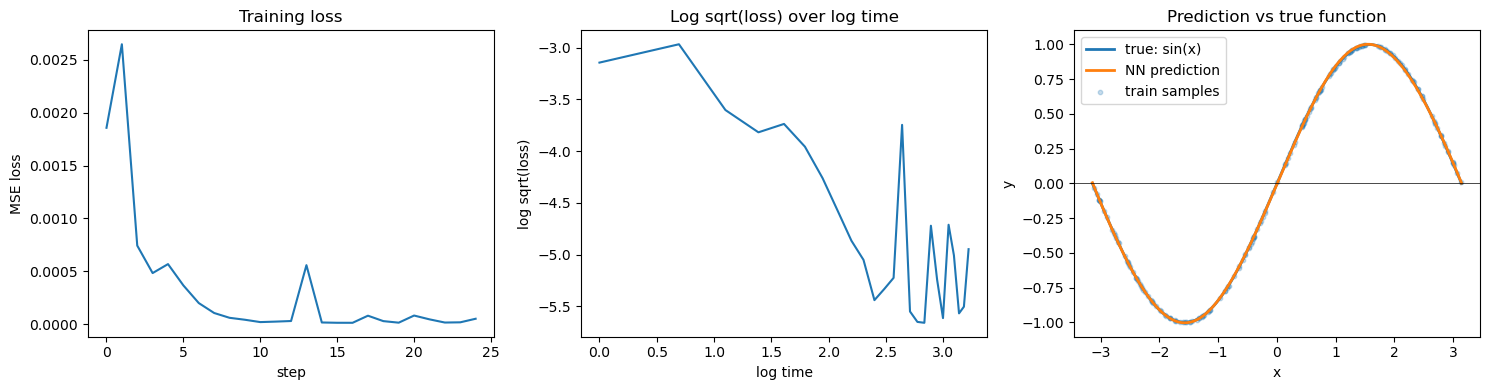

In [167]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# -------------------------------------------------
# 1) Training loss (MSE)
# -------------------------------------------------
axes[0].plot(losses)
axes[0].set_xlabel("step")
axes[0].set_ylabel("MSE loss")
axes[0].set_title("Training loss")

# -------------------------------------------------
# 2) Log–log plot of sqrt(loss)
# -------------------------------------------------
t = np.arange(1, len(losses) + 1)
axes[1].plot(np.log(t), np.log(np.sqrt(losses)))
axes[1].set_xlabel("log time")
axes[1].set_ylabel("log sqrt(loss)")
axes[1].set_title("Log sqrt(loss) over log time")

# -------------------------------------------------
# 3) Prediction vs true function
# -------------------------------------------------
x_grid = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1)
y_true = np.sin(x_grid)

x_grid_n = (x_grid - x_mean) / x_std
y_pred, _ = forward(x_grid_n, W1, b1, W2, b2)

axes[2].plot(x_grid, y_true, label="true: sin(x)", linewidth=2)
axes[2].plot(x_grid, y_pred, label="NN prediction", linewidth=2)
axes[2].scatter(x[:200], y[:200], s=10, alpha=0.25, label="train samples")
axes[2].axhline(0, color="black", linewidth=0.5)
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
axes[2].set_title("Prediction vs true function")
axes[2].legend()

plt.tight_layout()
plt.show()


## Glossary of Key Terms

| Term | Definition | Implementation in This Notebook |
|------|------------|------------------|
| **Neural Network** | A parameterised function composed of layers, where each layer applies an affine transformation followed by a nonlinear activation. | Two-layer network: $x \to W_1, b_1 \to \tanh \to W_2, b_2 \to \hat{y}$ |
| **Weights ($W$)** | Learnable parameters that define the linear component of each layer's transformation. | `W1` $\in \mathbb{R}^{1 \times H}$, `W2` $\in \mathbb{R}^{H \times 1}$ |
| **Bias ($b$)** | Learnable parameters that provide translation in the affine transformation. | `b1` $\in \mathbb{R}^{1 \times H}$, `b2` $\in \mathbb{R}^{1 \times 1}$ |
| **Activation Function** | Nonlinear function applied pointwise after affine transformations; essential for representational capacity. | $\tanh(z)$ in the hidden layer |
| **Layer** | A computational unit consisting of an affine transformation followed by an activation function. | Layer 1: $z_1 = x W_1 + b_1$, $a_1 = \tanh(z_1)$ |
| **Hidden Layer** | Intermediate layer(s) between input and output; outputs are not directly observed in the training data. | The $\tanh$ layer with $H = 32$ neurons |
| **Forward Pass** | Sequential evaluation of the network from input to output given current parameters. | `forward(xb, W1, b1, W2, b2)` |
| **Loss Function** | Objective function quantifying the discrepancy between predictions and targets; training seeks to minimise this. | MSE: $L = \frac{1}{N}\sum(\hat{y}_i - y_i)^2$ |
| **Backpropagation** | Algorithm for computing gradients of the loss with respect to all parameters via recursive application of the chain rule. | `backward(cache, yb, W2)` |
| **Gradient** | Vector of partial derivatives indicating the direction of steepest increase of the loss function. | `dW1`, `db1`, `dW2`, `db2` |
| **Chain Rule** | Calculus rule for differentiation of composite functions: $\frac{dL}{dw} = \frac{dL}{dy} \cdot \frac{dy}{dw}$ | Applied throughout backpropagation |
| **Learning Rate ($\eta$)** | Step size hyperparameter controlling the magnitude of parameter updates. | `lr = 0.1` |
| **Epoch** | One complete pass through the entire training dataset. | Each iteration in full-batch GD constitutes one epoch |
| **Batch** | A subset of training observations used to compute a single gradient estimate. | `batch = 128` observations in SGD |
| **Mini-batch SGD** | Gradient descent using random subsets of data to estimate gradients. | Second training loop with `batch = 128` |
| **Overfitting** | Phenomenon where the model achieves low training error but poor generalisation to unseen data. | (Not observed here; included for completeness) |
| **Normalisation** | Standardising inputs to have zero mean and unit variance. | `x_n = (x - x_mean) / x_std` |
| **Validation Set** | Data withheld from training to evaluate model performance on unseen examples. | `x_validation`, evaluated periodically |
| **Hyperparameters** | Configuration parameters set prior to training (not learned): learning rate, architecture, batch size, etc. | `lr = 0.1`, `Nh = 32`, `batch = 128`, `epochs = 20000` |
| **Universal Approximation** | Theorem establishing that neural networks can approximate continuous functions to arbitrary precision. | Theoretical justification for the approach |